In [ ]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tdoped.stabilizer import StabilizerOps
from tdoped.hamiltonian import HamiltonianTools
from tdoped.simulation import Simulator
from tdoped.toric import ToricCode

import itertools as it
import qiskit.quantum_info as qi
import scipy
from tqdm.auto import *

sns.set_theme()
sns.set_style("white")
sns.set_context('paper')
plt.style.use(['science', 'grid'])
mpl.rc('font', family='serif')
sns.set_palette("deep")

colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']
plt.rc('axes', prop_cycle=(plt.cycler('color', colors)))

We set up the model parameters and initialize the perturbations for the Toric Code. We define the size of the lattice `N` and create a perturbation matrix with specific coordinates. The Toric Code model is then instantiated with these perturbations. This setup is crucial for simulating the behavior of the system under different perturbations and analyzing the resulting quantum states.

In [3]:
N = 7
perturbation = np.zeros((3,4*N**2)).astype(int)
perturbation[0,ToricCode.coordinate(N,0,0,0)] = 1
perturbation[0,2*N**2+ToricCode.coordinate(N,0,0,1)] = 1
perturbation[1,ToricCode.coordinate(N,0,1,0)] = 1
perturbation[2,ToricCode.coordinate(N,1,0,0)] = 1
toric: ToricCode = ToricCode(N, perturbation=perturbation)

  0%|          | 0/94 [00:00<?, ?it/s]

In [4]:
ham_coeffs = -np.ones(len(toric.stabilizers))
ham_coeffs[-2:] = 0
np.random.seed(43)
pert_coeffs = np.random.rand(len(perturbation))
all_coeffs = np.concatenate([ham_coeffs, pert_coeffs])

transformed_stab = StabilizerOps.to_pauli(toric.stabilizers).evolve(toric.diagonalizing_cliff)
transformed_pert = StabilizerOps.to_pauli(toric.perturbation).evolve(toric.diagonalizing_cliff)

Calculate expectation values of two observables (i.e., two stabilizers of the toric code) as a function of time and perturbation strength.

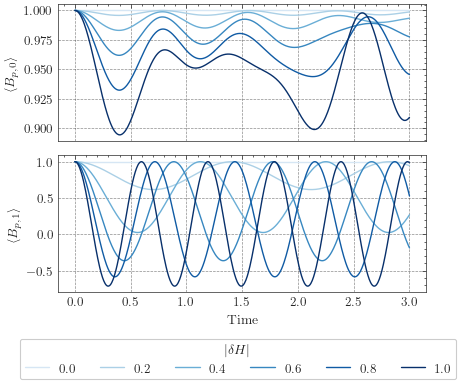

In [7]:
tf, num = 3, 6
time_points = np.linspace(0,tf,500)
colors = plt.cm.Blues(np.linspace(0, 1, num+1))
fig, axes = plt.subplots(2,1,sharex=True,figsize=(4.5,3.5))
op1, op2 = HamiltonianTools.reduced_p(transformed_stab[[1,3]], np.zeros(toric.S,))
sv0 = toric.unperturbed_ground_state
for i, c in enumerate(np.linspace(0, 8, num=num)):
    hx = Simulator.reduced_ham(toric.hamiltonian_data, np.concatenate([ham_coeffs, pert_coeffs*c]), np.zeros(toric.S, dtype=float))
    observable_values = np.real(Simulator.time_evolve(sv0, hx, t0=0, tf=tf, num=500, observables=[op1, op2]))
    axes[0].plot(time_points, observable_values[0], c=colors[i+1])
    axes[1].plot(time_points, observable_values[1], label=f'{i/(num-1)}', c=colors[i+1])

axes[0].set_ylabel(r'$\langle B_{p,0} \rangle$')
axes[1].set_ylabel(r'$\langle B_{p,1} \rangle$')
axes[1].set_xlabel(r'Time')
fig.legend(loc='upper center', bbox_to_anchor=(0.55,0.02), title=r'$|\delta H|$', ncol=6)
fig.tight_layout()
plt.show()

Calculate topological entanglement entropy as a function of time and perturbation strength.

In [8]:
def s_topo(vals):
    n = int(np.round(np.log(len(vals))/np.log(4)))
    vals = vals/2**n
    op = qi.SparsePauliOp([''.join(x) for x in it.product(["I", "X", "Y", "Z"], repeat=n)], coeffs=vals)
    rho = qi.DensityMatrix(op.to_matrix())
    partial_trace_systems = [[4,5],[0,1],[2,3],[2,3,4,5],[0,1,4,5],[0,1,2,3], []]
    AB, BC, CA, A, B, C, ABC = [scipy.stats.entropy(np.linalg.eigvalsh(qi.partial_trace(rho, sys)).clip(0,None), base=2) for sys in partial_trace_systems]
    
    return 2*(AB+BC+CA-A-B-C-ABC)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

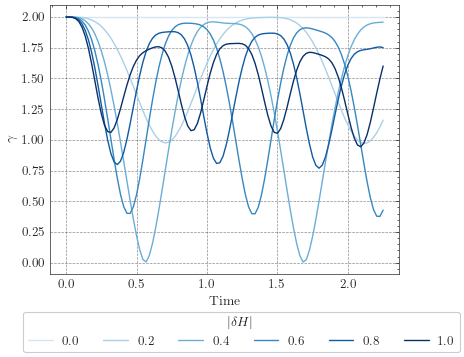

In [10]:
colors = plt.cm.Blues(np.linspace(0, 1, num+1))
num_ts = 100
fig, ax = plt.subplots(figsize=(4.5,3.5))
for i, c in enumerate(np.linspace(0, 8, num=num)):
    hx = Simulator.reduced_ham(toric.hamiltonian_data, np.concatenate([ham_coeffs, pert_coeffs*c]), np.zeros(toric.S, dtype=float), )
    _, transformed_obs = toric.get_sample_subsys_observables()
    observables = HamiltonianTools.reduced_p(transformed_obs, np.zeros(toric.S,))
    time_evolved = Simulator.time_evolve(sv0, hx, t0=0, tf=2.25, num=num_ts, observables=observables)
    ax.plot(np.linspace(0,2.25, num_ts), [s_topo(time_evolved[:,i]) for i in trange(num_ts, leave=False)], label=f'{i/(num-1)}', c=colors[i+1])
ax.set_ylabel(r'$\gamma$')
ax.set_xlabel(r'Time')
fig.legend(loc='upper center', bbox_to_anchor=(0.55,0.02), title=r'$|\delta H|$', ncol=6)

Perform Gibbs sampling.

  0%|          | 0/4000 [00:00<?, ?it/s]

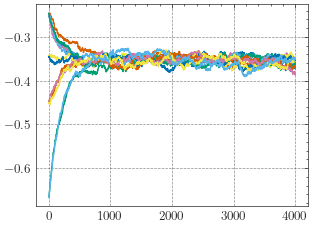

In [11]:
import jax.numpy as jnp
import jax

pert_idx = len(toric.stabilizers)
beta=1
coeffs = np.copy(all_coeffs)
coeffs[pert_idx] = 1
data = Simulator.gibbs_sample(toric.hamiltonian_data, coeffs, S=toric.S, beta=beta, copies=12, samples=4000)
sign_mat, phases, paulis = map(jnp.array, toric.hamiltonian_data)
op = toric.transformed_pert[0]
obs = HamiltonianTools.reduced_p(op, np.zeros(toric.S,))
is_z = np.array([x == 'Z' for x in op.to_label()]).astype(int)[:toric.S]

@jax.jit
def thermal_obs(x, all_coeffs, beta, obs):
    cs = (-1)**(sign_mat@x.T + phases[:,None]) * all_coeffs[:,None]
    h = jnp.einsum('ib,ikl->bkl', cs, paulis)
    eners, U = jnp.linalg.eigh(h)
    p = jax.nn.softmax(-beta*eners, axis=1)
    state = jnp.einsum('bij,bj,bkj->bik', U, p, jnp.conj(U))
    return jnp.real(jnp.einsum('bij,ji', state, obs)*(-1)**(x @ is_z))
thermal_obs_vec = jax.vmap(thermal_obs, in_axes=(0, None, None, None))

def moving_avg(x, alpha=0.05):
    x0 = x[0]
    ret = [x0]
    for i in range(1, len(x)):
        x0 = (1-alpha)*x0 + alpha*x[i]
        ret.append(x0)
    return np.array(ret)

plt.plot(moving_avg(thermal_obs_vec(data, coeffs, beta, obs), alpha=5e-3));

Calculate the topological entanglement entropy of the ground state of a perturbed toric code.

  0%|          | 0/20 [00:00<?, ?it/s]

Text(0.5, 0, '$|\\delta H|$')

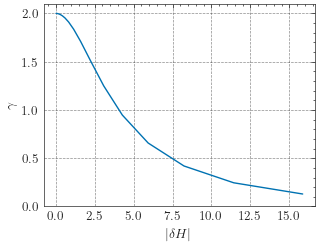

In [12]:
gammas = []
num = 20
for i, c in tqdm(list(enumerate(np.logspace(-1.5, 1.2, num=num)))):
    pert_idx = len(toric.stabilizers)
    coeffs = np.concatenate([ham_coeffs, pert_coeffs*c])
    x0, E0 = Simulator.ground_state(toric.hamiltonian_data, coeffs, S=toric.S, copies=10, steps=1000)
    h = Simulator.reduced_ham(toric.hamiltonian_data, coeffs, x=x0)
    eigstate = np.linalg.eigh(h)[1][:,0]
    _, transformed_obs = toric.get_sample_subsys_observables()
    observables = HamiltonianTools.reduced_p(transformed_obs, np.zeros(toric.S,))
    observable_values = np.einsum('i,kij,j', np.conj(eigstate), observables, eigstate)
    gammas.append(s_topo(observable_values))
plt.plot(np.logspace(-1.5, 1.2, num=num), gammas)
plt.ylim(0,None)
plt.ylabel(r'$\gamma$')
plt.xlabel(r'$|\delta H|$')